# Imports

In [2]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import gensim.downloader as api

2023-03-07 17:54:16.022781: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-07 17:54:16.344806: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-07 17:54:16.344834: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-07 17:54:16.395455: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-07 17:54:17.388029: W tensorflow/stream_executor/platform/de

# Data loading

In [4]:
X_movies = pd.read_csv("./../raw_data/sample_movies_reviews_clean.csv")
X_books = pd.read_csv("./../raw_data/sample_books_reviews_clean.csv")

### Extracting the lists out of the strings and removing unnecessary columns

In [5]:
X_books["txt_flatten"] = X_books["txt"].apply(lambda x: eval(x))
X_movies["txt_flatten"] = X_movies["txt"].apply(lambda x: eval(x))
X_movies.drop(columns=["Unnamed: 0", "txt"], inplace=True)
X_books.drop(columns=["Unnamed: 0", "txt"], inplace=True)

In [11]:
X_books_agg = X_books.groupby("item_id").sum()
X_movies_agg = X_movies.groupby("item_id").sum()
X_books_agg["is_movie"] = 0
X_movies_agg["is_movie"] = 1
X_books_agg.reset_index(inplace=True)
X_movies_agg.reset_index(inplace=True)
X_books_agg.rename({"item_id":"item_id_book"}, axis='columns', inplace=True)
X_movies_agg.rename({"item_id":"item_id_movie"}, axis='columns',inplace=True)
X_reviews = pd.concat([X_movies_agg, X_books_agg])

### Grouping the reviews by movies_id and book_id
### Adding a "is_movie" column to keep track of the category of each item
### Resetting index in order to keep the item_id for each book and movie

array([[<Axes: title={'center': 'txt_flatten'}>]], dtype=object)

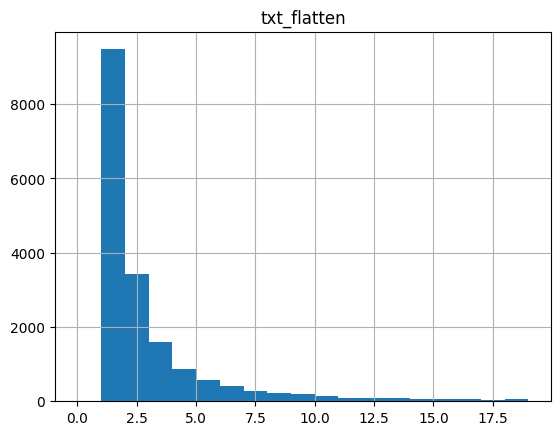

In [167]:
X_movies.groupby("item_id").count().hist(bins=[*range(20)])

array([[<Axes: title={'center': 'txt_flatten'}>]], dtype=object)

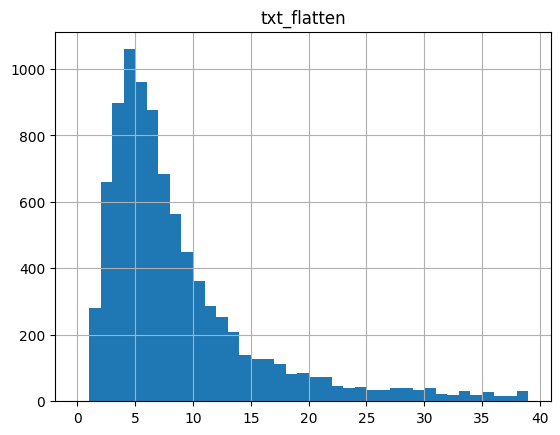

In [165]:
X_books.groupby("item_id").count().hist(bins=[*range(40)])

### Looking at the distribution of reviews lengths

In [170]:
X_movies_agg["length_txt"] = X_movies_agg["txt_flatten"].apply(lambda x: len(x))

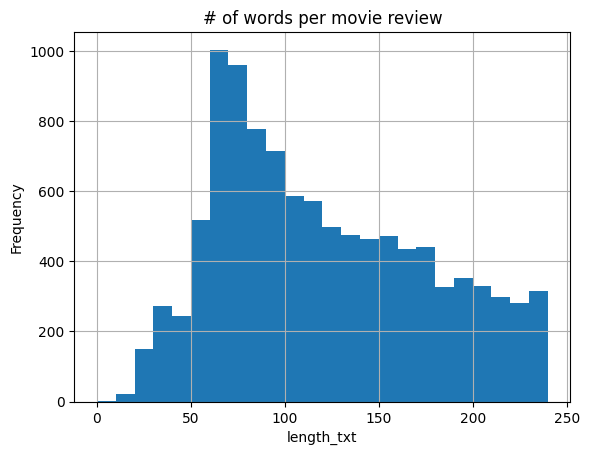

In [175]:
X_movies_agg["length_txt"].hist(bins=[*range(0,250,10)])
plt.xlabel("length_txt")
plt.ylabel("Frequency")
plt.title("# of words per movie review");

In [176]:
X_books_agg["length_txt"] = X_books_agg["txt_flatten"].apply(lambda x: len(x))

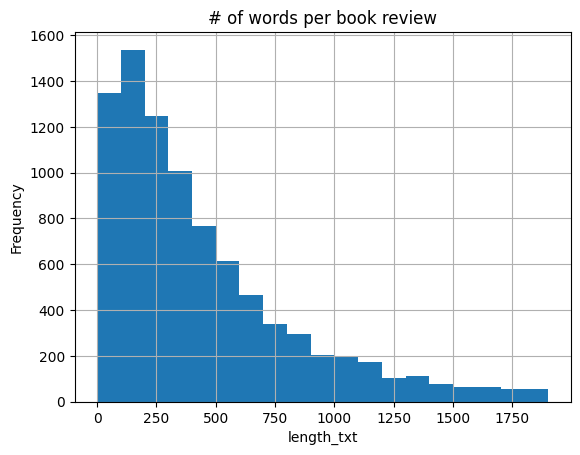

In [178]:
X_books_agg["length_txt"].hist(bins=[*range(0,2000,100)])
plt.xlabel("length_txt")
plt.ylabel("Frequency")
plt.title("# of words per book review");

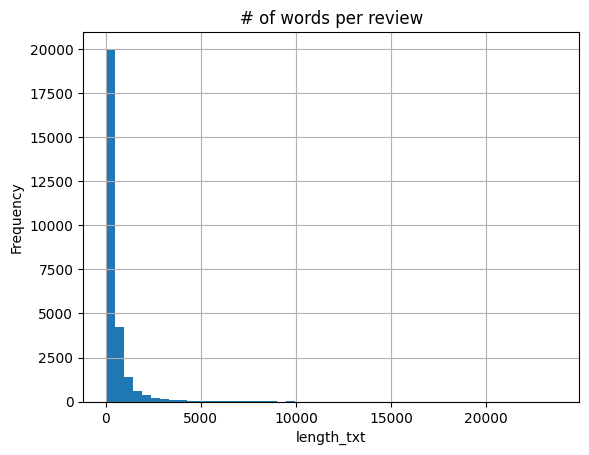

In [97]:
X_reviews["length_txt"].hist(bins=50)
plt.xlabel("length_txt")
plt.ylabel("Frequency")
plt.title("# of words per review (book + movie)");

# Word2Vec

In [7]:
# To list the available Word2Vec models
print(list(api.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [46]:
#TODO use another word2vec
#TODO utiliser BERT --> pas forcément besoin de preprocessing ?

In [45]:
word2vec_transfer = api.load("glove-wiki-gigaword-300")

In [47]:
# To list Word2Vec params
print(word2vec_transfer.vector_size)
print(len(word2vec_transfer.key_to_index))

300
400000


## Old embedding version

In [20]:
# Function to convert a sentence (list of words) into a matrix representing the words in the embedding space
def embed_sentence_with_TF(word2vec, sentence):
    embedded_sentence = []
    for word in sentence:
        if word in word2vec:
            embedded_sentence.append(word2vec[word])
        
    return np.array(embedded_sentence)

# Function that converts a list of sentences into a list of matrices
def embedding(word2vec, sentences):
    embed = []
    
    for sentence in sentences:
        embedded_sentence = embed_sentence_with_TF(word2vec, sentence)
        embed.append(embedded_sentence)
        
    return embed

In [21]:
# Embed the training and test sentences
# X_embed = embedding(word2vec_transfer, X_reviews["txt_flatten"])

In [24]:
# Pad the training and test embedded sentences
# TODO: maxlen could be increased
# X_pad = pad_sequences(X_embed, dtype='float32', padding='post', maxlen=1000, value=0)

: 

: 

In [22]:
np.shape(X_embed)

/home/arostagnat/.pyenv/versions/3.10.6/envs/BookMatch/lib/python3.10/site-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


(27372,)

In [28]:
np.shape(X_embed[3])

(218, 50)

## Vectorizing

In [9]:
def vectorize(list_of_docs, model):
    """Generate vectors for list of documents using a Word Embedding

    Args:
        list_of_docs: List of documents
        model: Gensim's Word Embedding

    Returns:
        List of document vectors
    """
    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model:
                try:
                    vectors.append(model[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features


In [48]:
vectorized_docs = vectorize(X_reviews["txt_flatten"], model=word2vec_transfer)

In [49]:
len(vectorized_docs), len(vectorized_docs[0])

(27372, 300)

In [ ]:
#TOD0: Use different clustering methods

In [21]:
from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering, Birch, BisectingKMeans
from sentence_transformers import SentenceTransformer

### MiniBatchKmeans (Old)

In [82]:
# km = MiniBatchKMeans(n_clusters=75, batch_size=500).fit(vectorized_docs)

/home/arostagnat/.pyenv/versions/3.10.6/envs/BookMatch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [84]:
X_reviews["batch_label"] = km.labels_

### Kmeans

In [50]:
N_CLUSTERS = 50

In [51]:
kmeans = KMeans(n_clusters=N_CLUSTERS).fit(vectorized_docs)

/home/arostagnat/.pyenv/versions/3.10.6/envs/BookMatch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [52]:
X_reviews["Kmeans_label"] = kmeans.labels_

### Agglomerative clustering

In [53]:
clustering = AgglomerativeClustering(n_clusters=N_CLUSTERS).fit(vectorized_docs)

In [54]:
X_reviews["clustering_label"] = clustering.labels_

### BisectingKMeans 

In [55]:
bisect_means = BisectingKMeans(n_clusters=N_CLUSTERS, random_state=1).fit(vectorized_docs)

In [56]:
X_reviews["bisectings"] = bisect_means.labels_

### BERT

In [ ]:
bert = SentenceTransformer('all-MiniLM-L6-v2')
bert_embeddings = bert.encode(vectorized_docs) #ou bien txt non vectorisé ? 

### Loading metadata and merging it

In [24]:
metadata_movies = pd.read_json("./../raw_data/raw_movies/metadata.json", lines=True)
metadata_books = pd.read_json("./../raw_data/raw_book/metadata.json", lines=True)

In [61]:
metadata_movies.rename({"item_id":"item_id_movie", "title":"movie_title"}, axis='columns',inplace=True)
metadata_books.rename({"item_id":"item_id_book", "title":"book_title"}, axis='columns',inplace=True)

In [62]:
merged_movies = pd.merge(X_reviews, metadata_movies, on="item_id_movie", how="left")
merged_all = pd.merge(merged_movies, metadata_books, on="item_id_book", how="left")

In [63]:
final_df = merged_all[["movie_title","book_title","clustering_label", "Kmeans_label", "bisectings", "is_movie" ]]
final_df = final_df.fillna("")
final_df["clustering_label"].value_counts()

2     1565
20    1493
0     1419
24    1277
14    1263
26    1110
8     1007
15     994
4      994
9      991
11     970
7      945
12     902
30     900
49     876
5      829
22     744
19     706
44     705
3      688
23     661
16     568
10     544
47     535
17     490
25     412
27     396
39     389
45     367
33     332
18     298
37     275
42     261
21     233
36     227
43     215
40     177
48     169
32     149
34      86
46      68
6       53
13      26
38      20
35      18
1       17
28       4
41       2
29       1
31       1
Name: clustering_label, dtype: int64

In [65]:
final_df[final_df["movie_title"].str.contains("potter", case=False)]

,movie_title,book_title,clustering_label,Kmeans_label,bisectings,is_movie
3360,Harry Potter and the Sorcerer's Stone (a.k.a. ...,,14,46,27,1
3964,Harry Potter and the Chamber of Secrets (2002),,14,46,17,1
5293,Harry Potter and the Prisoner of Azkaban (2004),,14,18,35,1
6914,Harry Potter and the Goblet of Fire (2005),,14,46,35,1
7485,Miss Potter (2006),,2,10,35,1
7754,Harry Potter and the Order of the Phoenix (2007),,14,10,35,1
8766,Harry Potter and the Half-Blood Prince (2009),,14,10,35,1
9694,Harry Potter and the Deathly Hallows: Part 1 (...,,14,46,35,1
10168,Harry Potter and the Deathly Hallows: Part 2 (...,,14,46,35,1


In [66]:
final_df[final_df["book_title"].str.contains("potter", case=False)]

,movie_title,book_title,clustering_label,Kmeans_label,bisectings,is_movie
20138,,Harry Potter and the Prisoner of Azkaban (Harr...,37,3,8,0
20232,,James Potter and the Hall of Elders' Crossing ...,0,45,40,0
20374,,Harry Potter and the Order of the Phoenix (Har...,30,45,48,0
20487,,"Harry Potter Boxset (Harry Potter, #1-7)",30,40,38,0
20488,,Harry Potter and the Deathly Hallows (Harry Po...,30,5,48,0
20550,,Harry Potter and the Goblet of Fire (Harry Pot...,30,32,48,0
20660,,"Harry, a History: The True Story of a Boy Wiza...",30,45,44,0
21074,,Harry Potter and the Sorcerer's Stone (Harry P...,30,12,44,0
21243,,Harry Potter and the Chamber of Secrets (Harry...,30,45,48,0
22320,,"Harry Potter: The Prequel (Harry Potter, #0.5)",20,12,44,0


In [31]:
final_df[final_df["clustering_label"]==4]

,title_x,title_y,clustering_label,Kmeans_label,bisectings,is_movie
0,Toy Story (1995),,4,3,72,1
6,Sabrina (1995),,4,58,19,1
14,Casino (1995),,4,52,14,1
34,"Cry, the Beloved Country (1995)",,4,58,72,1
55,From Dusk Till Dawn (1996),,4,64,14,1
...,...,...,...,...,...,...
17988,The Unfinished Dance (1947),,4,58,19,1
18000,Toilet - Ek Prem Katha (2017),,4,12,15,1
18018,The Phantom of the Opera (1998),,4,52,14,1
18671,,"The A.B.C. Murders (Hercule Poirot, #13)",4,73,20,0


### Silhouette plotting

In [ ]:
def mbkmeans_clusters(
	X, 
    k, 
    mb, 
    print_silhouette_values, 
):
    """Generate clusters and print Silhouette metrics using MBKmeans

    Args:
        X: Matrix of features.
        k: Number of clusters.
        mb: Size of mini-batches.
        print_silhouette_values: Print silhouette values per cluster.

    Returns:
        Trained clustering model and labels based on X.
    """
    km = MiniBatchKMeans(n_clusters=k, batch_size=mb).fit(X)
    print(f"For n_clusters = {k}")
    print(f"Silhouette coefficient: {silhouette_score(X, km.labels_):0.2f}")
    print(f"Inertia:{km.inertia_}")

    if print_silhouette_values:
        sample_silhouette_values = silhouette_samples(X, km.labels_)
        print(f"Silhouette values:")
        silhouette_values = []
        for i in range(k):
            cluster_silhouette_values = sample_silhouette_values[km.labels_ == i]
            silhouette_values.append(
                (
                    i,
                    cluster_silhouette_values.shape[0],
                    cluster_silhouette_values.mean(),
                    cluster_silhouette_values.min(),
                    cluster_silhouette_values.max(),
                )
            )
        silhouette_values = sorted(
            silhouette_values, key=lambda tup: tup[2], reverse=True
        )
        for s in silhouette_values:
            print(
                f"    Cluster {s[0]}: Size:{s[1]} | Avg:{s[2]:.2f} | Min:{s[3]:.2f} | Max: {s[4]:.2f}"
            )
    return km, km.labels_